In [43]:
import os
import sys
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from pathlib import Path
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from deep_sprl.util.gaussian_torch_distribution import GaussianTorchDistribution
from deep_sprl.util.cauchy_torch_distribution import CauchyTorchDistribution
from deep_sprl.experiments.point_mass_2d_heavytailed_experiment import PointMass2DHeavyTailedExperiment

In [44]:
DISTS = {
    "Gaussian": GaussianTorchDistribution,
    "Cauchy": CauchyTorchDistribution,
}

In [45]:
def sample(context_dist, context_bounds):
    sample_ok = False
    count = 0
    while not sample_ok and count < 100:
        sample = context_dist.sample().detach().numpy()
        sample_ok = np.all(context_bounds[0] <= sample) and (np.all(sample <= context_bounds[1]))
        count += 1

    if sample_ok:
        return sample
    else:
        mu = context_dist.mean()
        # Why uniform sampling? Because if we sample 100 times outside of the allowed
        if np.all(context_bounds[0] <= mu) and (np.all(mu <= context_bounds[1])):
            return np.random.uniform(context_bounds[0], context_bounds[1])
        else:
            return np.clip(sample, context_bounds[0], context_bounds[1])

In [46]:
def get_primary_contexts(base_dir, iterations, context_bounds, num_context=30, context_dim=2, dist_type="Gaussian"):
    primary_contexts = {}
    for iteration in iterations:
        dist_path = os.path.join(base_dir, f"iteration-{iteration}", "teacher.npy")
        dist = DISTS[dist_type].from_weights(context_dim, np.load(dist_path))
        p_contexts = []
        for num_c in range(num_context):
            p_contexts.append(sample(context_dist=dist, context_bounds=context_bounds))
        primary_contexts[iteration] = np.array(p_contexts)
    return primary_contexts

In [47]:
def get_auxiliary_contexts(base_dir, iterations, context_bounds, num_context=20, context_dim=2):
    auxiliary_contexts = {}
    for iteration in iterations:
        filename = os.path.join(base_dir, f"iteration-{iteration}", "cem.cem")
        with open(filename, 'rb') as h:
            obj = pkl.load(h)
        title, original_dist, batch_size, w_clip, \
        ref_mode, ref_alpha, n_orig_per_batch, internal_alpha, \
        ref_scores, sample_dist, sampled_data, weights, scores, \
        ref_quantile, internal_quantile, selected_samples = obj
        dist = sample_dist[-1]

        a_contexts = []
        for num_c in range(num_context):
            a_contexts.append(sample(context_dist=dist, context_bounds=context_bounds))
        auxiliary_contexts[iteration] = np.array(a_contexts)
    return auxiliary_contexts

In [48]:
base_log_dir = os.path.join(Path(os.getcwd()), "logs")
target_type = "wide"
env = f"point_mass_2d_heavytailed_{target_type}"
algorithm = "self_paced_with_cem"
model = "ppo_DELTA=4.0_DIST_TYPE=cauchy_KL_EPS=0.25_RALPH=0.2_RALPH_IN=1.0_RALPH_SCH=20"
seed = 1
iterations = [0, 20, 75, 195]
NUM_PRIMARY = 50
NUM_AUXILIARY = 50
dist_type="Cauchy"
context_bounds = [PointMass2DHeavyTailedExperiment.LOWER_CONTEXT_BOUNDS, PointMass2DHeavyTailedExperiment.UPPER_CONTEXT_BOUNDS]
base_dir = os.path.join(base_log_dir, env, algorithm, model, f"seed-{seed}")

In [49]:
primary_contexts = get_primary_contexts(base_dir=base_dir, iterations=iterations, context_bounds=context_bounds, num_context=NUM_PRIMARY, context_dim=2, dist_type=dist_type)
auxiliary_contexts = get_auxiliary_contexts(base_dir=base_dir, iterations=iterations, context_bounds=context_bounds, num_context=NUM_AUXILIARY, context_dim=2)

In [50]:
primary_contexts

{0: array([[-0.11035306,  4.744708  ],
        [-0.6120613 ,  5.3218346 ],
        [ 3.609674  ,  1.5099595 ],
        [ 1.8352908 ,  5.5152802 ],
        [ 1.4206343 ,  4.4125056 ],
        [ 1.4304012 ,  4.023101  ],
        [ 0.5097743 ,  5.5879536 ],
        [ 3.2445498 ,  2.396821  ],
        [ 0.5482521 ,  3.6982174 ],
        [-2.2337916 ,  4.1648307 ],
        [ 4.6146846 ,  4.6130505 ],
        [ 0.33432344,  3.6975973 ],
        [-1.870664  ,  5.1655464 ],
        [ 0.29675487,  2.1605387 ],
        [ 2.3599186 ,  4.309526  ],
        [ 3.2196898 ,  4.532088  ],
        [ 0.9405433 ,  3.5282679 ],
        [ 0.48106325,  3.6925068 ],
        [ 0.9760685 ,  1.5205426 ],
        [-1.2564328 ,  5.9085236 ],
        [ 0.09646318,  4.6916924 ],
        [-1.2370474 ,  3.9711945 ],
        [-0.676156  ,  3.8941333 ],
        [-0.8117933 ,  2.9786224 ],
        [-0.161532  ,  5.381177  ],
        [-0.02300585,  6.575129  ],
        [-0.1387638 ,  3.7802038 ],
        [ 0.5900599 ,  5.

In [51]:
auxiliary_contexts

{0: array([[ 4.776542  , 13.740531  ],
        [ 3.6106813 ,  1.3999801 ],
        [-0.46510547,  6.6344347 ],
        [ 6.0499945 ,  4.026637  ],
        [ 6.030886  ,  2.2876978 ],
        [-2.4323263 ,  1.2845502 ],
        [ 2.5558326 ,  4.4476986 ],
        [ 0.9848921 ,  3.706436  ],
        [-1.571673  , 13.236879  ],
        [-0.20268528,  2.4004085 ],
        [-4.1450214 ,  3.1254354 ],
        [ 0.6393581 ,  3.5421715 ],
        [-0.2885642 ,  1.7496185 ],
        [-0.33594987,  4.373143  ],
        [ 0.24296515,  5.6463494 ],
        [ 1.4111689 ,  4.8821015 ],
        [-0.97474134,  3.7432628 ],
        [ 0.11543946,  5.4154    ],
        [-6.73521   ,  8.361624  ],
        [-2.2063584 , 12.757727  ],
        [ 0.27315652,  3.894613  ],
        [-6.2493763 ,  5.639357  ],
        [ 0.43600908,  5.8656664 ],
        [ 2.2569337 ,  5.976996  ],
        [-0.05247818,  3.9739826 ],
        [-0.02515057,  4.20381   ],
        [ 0.05522956,  2.5061917 ],
        [ 1.95341   ,  7.

In [52]:
chosen_its = {0: "left",
              1: "top",
              2: "right",
              3: "bottom"}
def get_chosen_contexts(contexts):
    chosen = {}
    for i, pos in chosen_its.items():
        iter = iterations[i]
        cs = contexts[iter]
        if pos == "left":
            c = cs[np.argmin(cs[:, 0]), :]
        elif pos == "top":
            c = cs[np.argmax(cs[:, 1]), :]
        elif pos == "right":
            c = cs[np.argmax(cs[:, 0]), :]
        elif pos == "bottom":
            c = cs[np.argmin(cs[:, 1]), :]
        chosen[i] = c
    return chosen

In [53]:
auxiliary_chosen = get_chosen_contexts(auxiliary_contexts)
primary_chosen = get_chosen_contexts(primary_contexts)

In [54]:
def draw_env(ax, pos, width):
    ax.plot([context_bounds[0][0]-1, pos - (0.5 * width + 0.5)], [-0.1, -0.1], linewidth=5, color="black")
    ax.plot([pos + (0.5 + 0.5 * width), context_bounds[1][0]+1], [-0.1, -0.1], linewidth=5, color="black")

    ax.scatter([0.], [3.], s=50, color="black")
    ax.plot([-0.25, 0.25], [-3.25, -2.75], linewidth=5, color="red")
    ax.plot([-0.25, 0.25], [-2.75, -3.25], linewidth=5, color="red")
    ax.set_xlim([context_bounds[0][0], context_bounds[1][0]])
    ax.set_ylim([-4, 4])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params('both', length=0, width=0, which='major')

In [114]:
figsize = (10.0, 7.0)
fontsize = 16
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = fontsize
def plot_point_mass_context_space(contexts, iterations, curriculum_colors, chosen_contexts, figname, pm_boxes_arrows):
    f = plt.figure(figsize=figsize)
    ax = plt.Axes(f, [0.178, 0.08, 0.6435, 0.85])
    f.add_axes(ax)
    ax.set_xlim(context_bounds[0][0], context_bounds[1][0])
    ax.set_ylim(context_bounds[0][1], context_bounds[1][1])
    ax.spines['bottom'].set_position(('data', 0.5))
    ax.spines['left'].set_position('zero')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([context_bounds[0][0]+1, context_bounds[1][0]-1])
    ax.set_xticklabels([f'{int(context_bounds[0][0]+1)}', f'{int(context_bounds[1][0]-1)}'], fontsize=int(fontsize*1.5))
    ax.set_yticks([context_bounds[1][1]/2])
    ax.set_yticklabels([f'{int(context_bounds[1][1]/2)}'], fontsize=int(fontsize*1.5))
    ax.set_xticks(np.arange(int(context_bounds[0][0]+1), int(context_bounds[1][0]+1)), major=True)
    ax.set_yticks(np.arange(0., int(context_bounds[1][1])))
    ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)
    arrow_fmt = dict(markersize=4, color='black', clip_on=False)
    ax.plot((1), (0.5), marker='>', transform=ax.get_yaxis_transform(), **arrow_fmt)
    ax.plot((0), (1), marker='^', transform=ax.get_xaxis_transform(), **arrow_fmt)
    for itx, it in enumerate(iterations):
        ax.scatter(contexts[it][:, 0], contexts[it][:, 1], c=curriculum_colors[itx], label=f"it: {it}", s=70)
    ax.annotate("Width", xy=(0.,14.), fontsize=int(fontsize*1.5))
    ax.annotate("Position", xy=(7.,0.), fontsize=int(fontsize*1.5))
    for itx, (it, c) in enumerate(chosen_contexts.items()):
        arrow_end = pm_boxes_arrows[itx][1] - c
        ax.arrow(c[0], c[1], arrow_end[0], arrow_end[1], head_width=.3, color="r")
        ax_pm = plt.Axes(f, pm_boxes_arrows[itx][0])
        f.add_axes(ax_pm)
        draw_env(ax_pm, c[0], c[1])
        ax_pm.set_title(f"Curriculum Iteration {iterations[it]}\n"r"$\mathbf{c}=$"+f"({c[0]:.2f}, {c[1]:.2f})")
    plt.savefig(f"{figname}.pdf", dpi=500, bbox_inches='tight')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

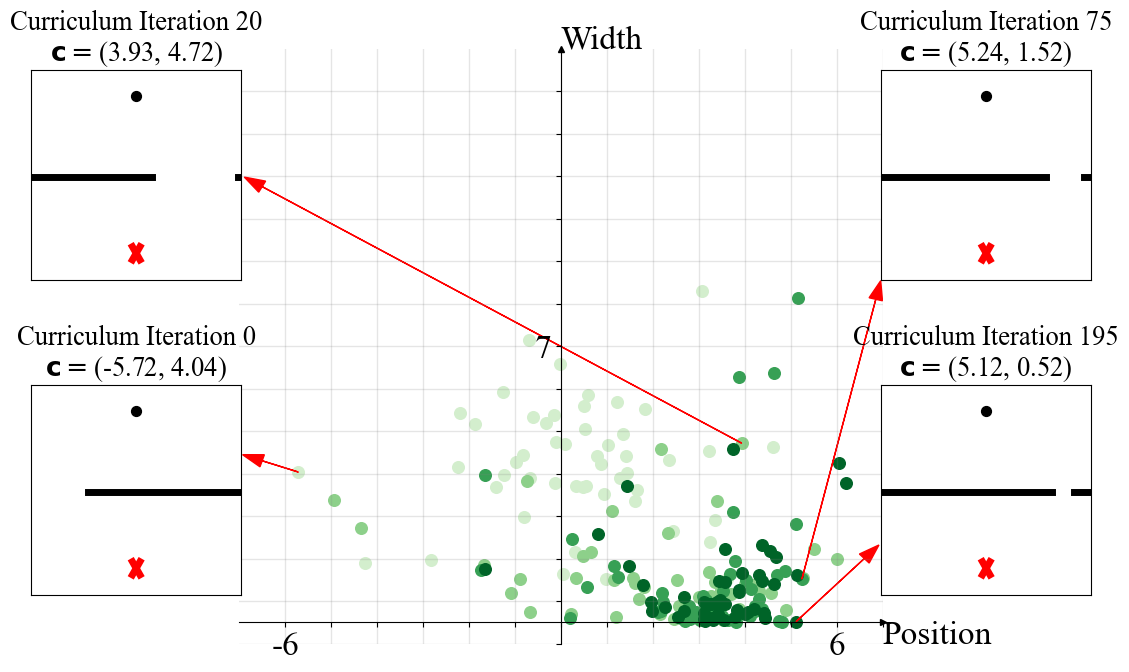

In [119]:
curriculum_colors = plt.get_cmap('Greens')(np.linspace(0.2, 0.9, len(iterations)))
pm_boxes_arrows = [
    ([-0.03, 0.15, 0.21, 0.3], [-6.5, 4.3]),
    ([-0.03, 0.6, 0.21, 0.3], [-6.5, 10.75]),
    ([0.82, 0.6, 0.21, 0.3], [6.85, 8.1]),
    ([0.82, 0.15, 0.21, 0.3], [6.6, 2]),
]
figname = f"figures\\{env}_{algorithm}_primary_contexts_evolution"
plot_point_mass_context_space(primary_contexts, iterations, curriculum_colors, primary_chosen, figname, pm_boxes_arrows)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

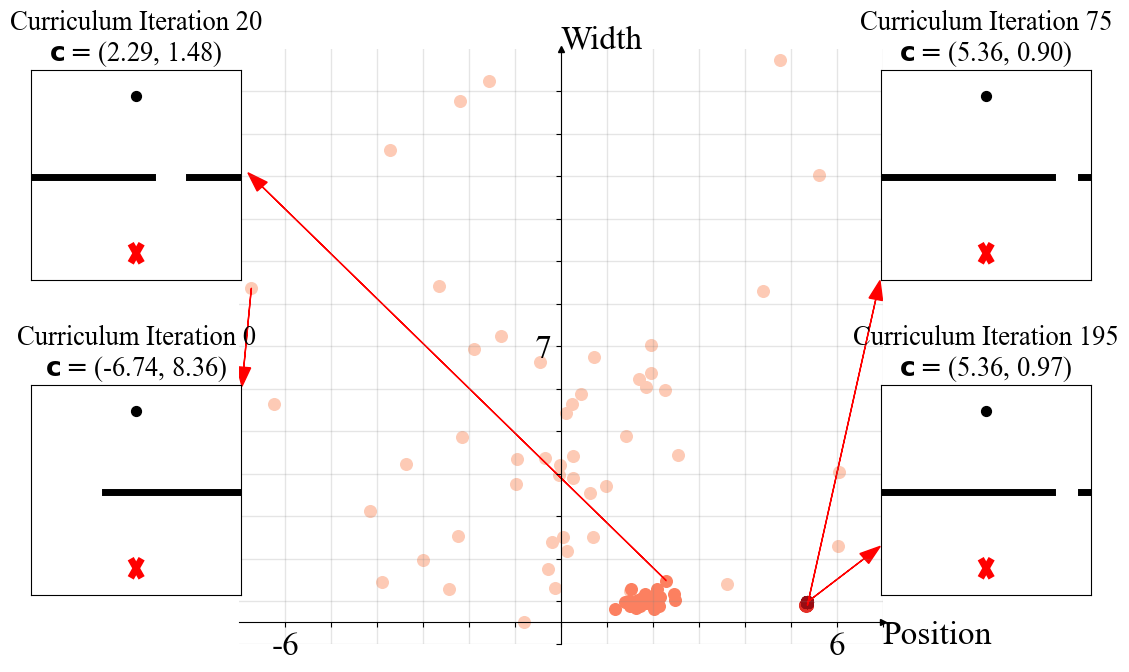

In [125]:
curriculum_colors = plt.get_cmap('Reds')(np.linspace(0.2, 0.9, len(iterations)))
pm_boxes_arrows = [
    ([-0.03, 0.15, 0.21, 0.3], [-6.9, 6.5]),
    ([-0.03, 0.6, 0.21, 0.3], [-6.5, 10.75]),
    ([0.82, 0.6, 0.21, 0.3], [6.85, 8.1]),
    ([0.82, 0.15, 0.21, 0.3], [6.6, 2]),
]
figname = f"figures\\{env}_{algorithm}_auxiliary_contexts_evolution"
plot_point_mass_context_space(auxiliary_contexts, iterations, curriculum_colors, auxiliary_chosen, figname, pm_boxes_arrows)